In [1]:
import pandas as pd
import numpy as np
import math
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path


import matplotlib.pyplot as plt

import SMOTE
import feature_selector
import DE
import CFS
import birch
import metrics.abcd

import metrices
import measures

import sys
import traceback
import warnings

import seaborn as sns

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def prepare_data(path):
    df = pd.read_csv(path)
    df = df.drop(labels = ['Host','Vcs','Project','File','PL','IssueTracking'],axis=1)
    df = df.dropna()
    df = df[['TLOC', 'TNF', 'TNC', 'TND', 'LOC', 'CL', 'NStmt', 'NFunc',
       'RCC', 'MNL', 'avg_WMC', 'max_WMC', 'total_WMC', 'avg_DIT', 'max_DIT',
       'total_DIT', 'avg_RFC', 'max_RFC', 'total_RFC', 'avg_NOC', 'max_NOC',
       'total_NOC', 'avg_CBO', 'max_CBO', 'total_CBO', 'avg_DIT.1',
       'max_DIT.1', 'total_DIT.1', 'avg_NIV', 'max_NIV', 'total_NIV',
       'avg_NIM', 'max_NIM', 'total_NIM', 'avg_NOM', 'max_NOM', 'total_NOM',
       'avg_NPBM', 'max_NPBM', 'total_NPBM', 'avg_NPM', 'max_NPM', 'total_NPM',
       'avg_NPRM', 'max_NPRM', 'total_NPRM', 'avg_CC', 'max_CC', 'total_CC',
       'avg_FANIN', 'max_FANIN', 'total_FANIN', 'avg_FANOUT', 'max_FANOUT',
       'total_FANOUT', 'NRev', 'NFix', 'avg_AddedLOC', 'max_AddedLOC',
       'total_AddedLOC', 'avg_DeletedLOC', 'max_DeletedLOC',
       'total_DeletedLOC', 'avg_ModifiedLOC', 'max_ModifiedLOC',
       'total_ModifiedLOC','Buggy']]
    return df

def get_features(df):
    fs = feature_selector.featureSelector()
    df,_feature_nums,features = fs.cfs_bfs(df)
    return df,features

def apply_cfs(df):
    y = df.Buggy.values
    X = df.drop(labels = ['Buggy'],axis = 1)
    X = X.values
    selected_cols = CFS.cfs(X,y)
    cols = df.columns[[selected_cols]].tolist()
    cols.append('Buggy')
    return df[cols],cols
    
def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def load_data(path,target):
    df = pd.read_csv(path)
    if path == 'data/jm1.csv':
        df = df[~df.uniq_Op.str.contains("\?")]
    y = df[target]
    X = df.drop(labels = target, axis = 1)
    X = X.apply(pd.to_numeric)
    return X,y

# Cluster Driver
def cluster_driver(df,print_tree = True):
    X = df.apply(pd.to_numeric)
    cluster = birch.birch(branching_factor=20)
    #X.set_index('Project Name',inplace=True)
    cluster.fit(X)
    cluster_tree,max_depth = cluster.get_cluster_tree()
    #cluster_tree = cluster.model_adder(cluster_tree)
    if print_tree:
        cluster.show_clutser_tree()
    return cluster,cluster_tree,max_depth

In [3]:
def get_predicted(cluster_data_loc,metrices_loc,fold,data_location):
    train_data = pd.read_pickle(cluster_data_loc + '/train_data.pkl')
    project = train_data.index.values.tolist()
    _s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + project[0]
    s_df = prepare_data(_s_path)
    s_cols = s_df.columns
    train_data.columns = s_cols
    result = train_data.sum(axis = 0)
    return result.values.tolist(),s_cols

In [4]:
final_list = []
for i in range(1):
    fold = str(i)
    data_location = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/exp_cdom_v6/fold_' + fold
    cluster_data_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/2/fold_' + fold
    metrices_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
    results,s_cols = get_predicted(cluster_data_loc,metrices_loc,fold,data_location)
    final_list.append(results)
final_df = pd.DataFrame(final_list,columns=s_cols)


In [15]:
items = {}
for i in range(final_df.iloc[0].shape[0]):
    x = final_df.iloc[0].index[i].split('_')
    if len(x) > 1:
        if x[1] not in items.keys():
            items[x[1]] = 0
        items[x[1]] = items[x[1]] + final_df.iloc[0].iloc[i]
    else:
        if x[0] not in items.keys():
            items[x[0]] = 0
        items[x[0]] = final_df.iloc[0].iloc[i]
    #print(final_df.iloc[0].index[i],final_df.iloc[0].iloc[i])
items_df = pd.DataFrame.from_dict(items,orient='index',columns=['ob'])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))    
y_pos = range(len(items_df)-1)
explode = (1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0)
y = items_df.sort_values(by=['ob'],ascending=False)
plt.pie(y.ob.values.tolist()[1:],labels=y.index.tolist()[1:],explode=explode,
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()    
y_pos = range(len(items_df)-1)
explode = (1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0)
y = items_df.sort_values(by=['ob'],ascending=False)
for i in range(len(y.values.tolist())-1):
    plt.pie([y.ob.values.tolist()[1:][i],697-y.ob.values.tolist()[1:][i]],labels=[y.index.tolist()[1:][i],'other'])
    plt.tight_layout()
    plt.plot()
    plt.show()

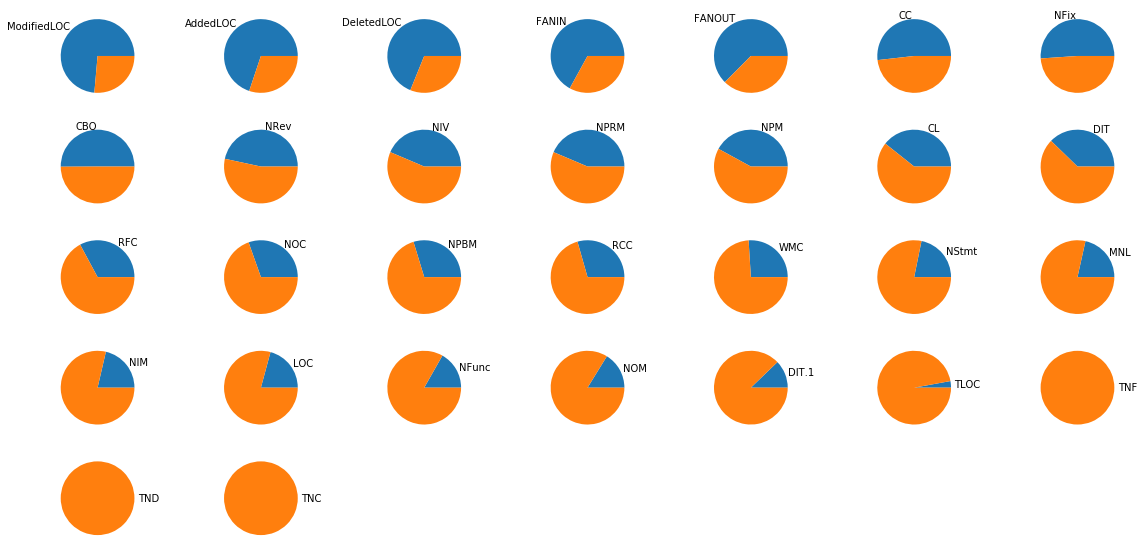

In [16]:
fig = plt.figure(num=None, figsize = (20,20), facecolor='w', edgecolor='k')
i = 0
j = 0
y = items_df.sort_values(by=['ob'],ascending=False)
for x in range(len(y.values.tolist())-1):
    if i == 10:
        i = 0
    if j == 7:
        j = 0
        i += 1
    ax = plt.subplot2grid((10,7),(i,j))
    j += 1
    ax.pie([y.ob.values.tolist()[1:][x],697-y.ob.values.tolist()[1:][x]],labels=[y.index.tolist()[1:][x],''])
plt.plot()
plt.show()